# Lab project preparation


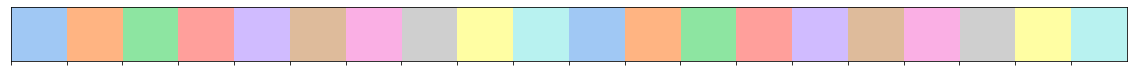

In [143]:
import numpy as np
import matplotlib as mpl
from iminuit import Minuit
import seaborn as sns
import sys
from scipy import stats
import matplotlib.pyplot as plt

colors = sns.color_palette('pastel', 20, desat =1)
sns.set_palette(colors)
sns.palplot(colors)

In [144]:
r = np.random

save_plots = False # For now, don't save plots (once you trust your code, switch on)
verbose = True     # For now, print a lot of output (once you trust your code, switch off)
Nverbose = 10      # But only print a lot for the first 10 random numbers

mpl.rcParams['font.size'] = 18      # Set the general plotting font size

In [145]:


def accel_fit(x_data, a, b, c):
    f = 0.5*a*x_data**2 + b * x_data + c
    return f






___
Jeppe
___


array([0.     , 0.27681, 0.45885, 0.60814, 0.72784])

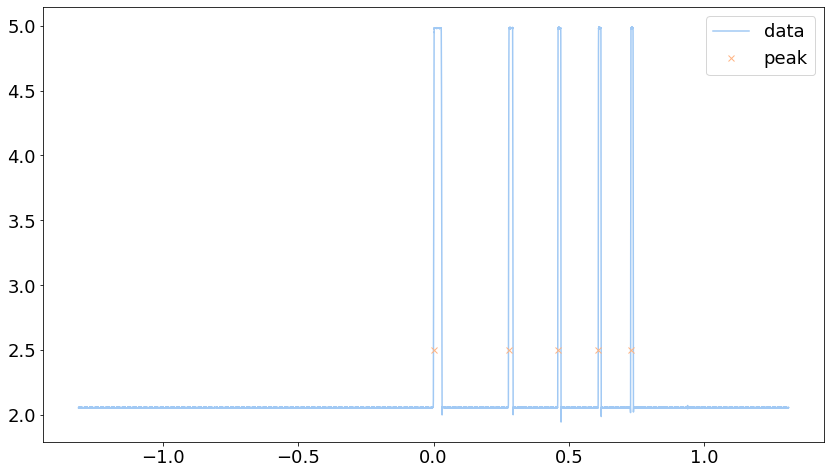

In [146]:
#data = np.genfromtxt('data.txt', delimiter= '')
data = np.genfromtxt('exp_R_L_LARGE.csv', delimiter = ',')
time = data[:,0]
voltage = data[:,1]

lens = np.array([84.55,66.75,48.65,29.85,12.30] )*1e-2 # jeppe
lens = np.array([14.65,32.45,50.57,69.35,83.82])*1e-2 # robin
lens = np.array([0.171, 0.351, 0.530,.719, 0.896])
lens = lens-lens[0]

time_exp =[]
for i in range(len(voltage) - 1):
    if voltage[i] <= 2.5 and voltage[i+1] > 2.5:
        time_exp.append(time[i])
    
if len(time_exp)> 5:
     time_exp= time_exp[:5]


time_exp = np.array(time_exp)-time_exp[0]
fig,ax = plt.subplots(figsize = (14,8))
ax.plot(time, voltage, label= 'data')
ax.plot(time_exp, np.ones(5)*2.5, 'x', label = 'peak')
ax.legend()
display(time_exp)


Fit value: a = 1.56141 +/- 0.01607
Fit value: b = 0.42636 +/- 0.00605
Fit value: c = 0.00045 +/- 0.00098
Chi2 value: 5.9   Ndof = 2    Prob(Chi2,Ndof) = 0.053


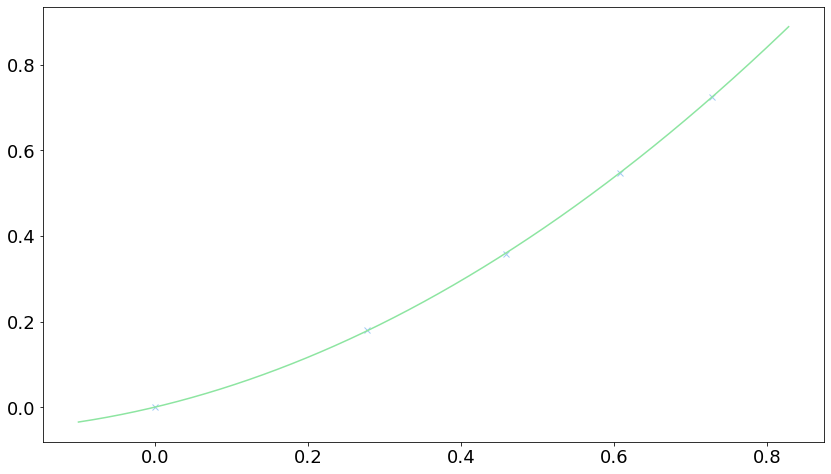

In [147]:

fig, ax = plt.subplots(figsize = (14,8))
time_exp = np.array(time_exp) 
ax.plot(time_exp, lens, 'x')


sy = .05*1e-2 # in m
sy = 1e-3
ax.errorbar(time_exp, lens, yerr = sy, fmt = 'none')



def chi2_owncalc(a, b, c) :
    y_fit = accel_fit(time_exp, a, b,c)
    chi2 = np.sum(
        (lens - y_fit)**2/
        sy**2
    )
        
    return chi2


minuit_chi2 = Minuit(chi2_owncalc, a=1, b=0.5, c = 0)
minuit_chi2.limits["a"] = (0, None)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output

for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")


# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(time_exp > 0)
Ndof_value = 5 - minuit_chi2.nfit

Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")
dummy = np.linspace(time_exp.min() -0.1, time_exp.max()+0.1, 1000)
ax.plot(dummy, accel_fit(dummy, *minuit_chi2.values[:]))



In [148]:
def angle_from_trig(length, height):
    return np.arctan(height/length)
def dangle_from_trig(length, d_length, height, d_height):
    return np.sqrt(
        (length/(length**2 + height**2)*d_height)**2
        +
        (height/(length**2 + height**2)*d_length)**2
    )



In [149]:
hh = 22.30e-2
d_hh = 0.1e-2
ll = 90.2e-2
d_ll= 0.1e-2

print(angle_from_trig(ll,hh))
print(dangle_from_trig(ll,d_ll, hh, d_hh))
#sp.N(sp.deg(0.24236838453429252))




0.24236838453429252
0.001076244212770436


In [150]:
import sympy as sp
from sympy.abc import theta, a, D, d

In [159]:
vin_R_L =13.9
d_vin_R_L = 0.1
vin_L_R = 13.9
d_vin_L_R = 0.1

vin = angle_from_trig(ll,hh) # measured angle
#vin = sp.rad(vin_R_L)
accc = minuit_chi2.values[0] # acceleration from fit
Ds_Large = 0.015  # measuered diameter of ball
Ds_small = np.mean([12.7,12.7,12.7])*1e-3


Ds = Ds_Large
ds = 0.0059  # measuered diameter of rail




d_theta = dangle_from_trig(ll,d_ll, hh, d_hh)  # estimated error on angle
#d_theta = sp.rad(d_vin_R_L)
#d_theta = 0.0005839522540269826
d_a = minuit_chi2.errors[0] # error from fit
d_D = 0.0005  # estimated error on diatmer of ball
d_d = 0.0005 # estimated error on rail





In [160]:


g = ((a / 
     sp.sin(theta))  *
( 1 
 + 
 (2/5)*(D**2)/(D**2-d**2))
)

def jeppe(prin = False):
    f_d_theta = sp.diff(g, theta)
    f_d_a = sp.diff(g,a)
    f_d_D = sp.diff(g,D)
    f_d_d = sp.diff(g,d)
    if prin:
        display(f_d_theta); print('=', sp.N(f_d_theta.subs(theta, vin).subs(a, accc).subs(D,Ds).subs(d,ds)*d_theta)**2)
        display(f_d_a); print('=', sp.N(f_d_a.subs(theta, vin).subs(a, accc).subs(D,Ds).subs(d,ds)*d_a)**2)
        display(f_d_D); print('=', sp.N(f_d_a.subs(theta, vin).subs(a, accc).subs(D,Ds).subs(d,ds)*d_D)**2)
        display(f_d_d); print('=', sp.N(f_d_a.subs(theta, vin).subs(a, accc).subs(D,Ds).subs(d,ds)*d_d)**2)
    
    return sp.N(sp.sqrt(
        (f_d_theta.subs(theta, vin).subs(a, accc).subs(D,Ds).subs(d,ds)*d_theta)**2
        +
         (f_d_a.subs(theta, vin).subs(a, accc).subs(D,Ds).subs(d,ds)*d_a)**2
         +
          (f_d_D.subs(theta, vin).subs(a, accc).subs(D,Ds).subs(d,ds)*d_D)**2
          +
           (f_d_d.subs(theta, vin).subs(a, accc).subs(D,Ds).subs(d,ds)*d_d)**2
    ))



In [161]:
minuit_chi2.values["a"]

1.5614090082858354

In [162]:
def print_result():
    g = ((minuit_chi2.values[0] / 
     sp.sin(vin))  *
( 1 
 + 
 (2/5)*(Ds**2)/(Ds**2-ds**2))
    )
    print(sp.N(g), '\pm', jeppe())

In [163]:
print_result()

9.58442230575202 \pm 0.148342291252851


In [164]:
print_result()

9.58442230575202 \pm 0.148342291252851


In [165]:
"endnu en test"

'endnu en test'

In [166]:
jeppe(prin=True)

-a*(0.4*D**2/(D**2 - d**2) + 1)*cos(theta)/sin(theta)**2

= 0.00174083211396341


(0.4*D**2/(D**2 - d**2) + 1)/sin(theta)

= 0.00973253536661670


a*(-0.8*D**3/(D**2 - d**2)**2 + 0.8*D/(D**2 - d**2))/sin(theta)

= 9.41973163024855e-6


0.8*D**2*a*d/((D**2 - d**2)**2*sin(theta))

= 9.41973163024855e-6


0.148342291252851